# Load Libraries

In [ ]:
# Import necessary libraries
import pandas as pd  # Library for data manipulation and analysis
import numpy as np  # Library for numerical computing
import glob  # Library for file handling
import re  # Library for regular expressions
from tqdm import tqdm  # Library for creating progress bars

import plotly.graph_objects as go  # Library for creating interactive plots

# Preprocessing
from sklearn import preprocessing  # Library for data preprocessing
import keras  # Deep learning library
from keras.models import Sequential  # Sequential model for stacking layers
from keras.layers.core import Dense, Dropout, Activation  # Layers for fully connected neural networks
from keras.layers import LSTM  # LSTM layer for sequence modeling
from keras.models import load_model  # Loading pre-trained models
import matplotlib.pyplot as plt  # Library for basic data visualization
import h5py  # Library for handling large datasets
import datetime  # Library for date and time operations
import tensorflow as tf  # Deep learning library



In [ ]:
import tensorflow as tf  # Import the TensorFlow library
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Print the number of available GPUs

In [ ]:
# These lines use the glob module to find all file paths that match the pattern 'GreenD_reduced_version_03/*.csv'. 
# The resulting file paths are stored in path_lists.
# Then, the file paths are sorted alphabetically and assigned to sorted_file_paths
path_lists = glob.glob('GreenD_reduced_version_03/'+'*.csv')
sorted_file_paths = sorted(path_lists)


# This code defines a function extract_digits that takes a string as input and 
# uses regular expressions (re.findall()) to extract digits from the string. 
# It returns the extracted digits as an integer if they exist, otherwise it returns 0.
# Then, the sorted() function is used with key=extract_digits to sort the file
# paths based on the digits extracted from each path. Finally, the sorted file paths are printed
def extract_digits(string):
    # Extract digits from the string using regular expression
    digits = re.findall(r'\d+', string)
    return int(digits[0]) if digits else 0

sorted_file_paths = sorted(path_lists, key=extract_digits)
print(sorted_file_paths)


# In this block of code, an empty list conct_list is created. Then, a loop is executed over each sorted
# file path using sorted_file_paths. Inside the loop, each CSV file is read using pd.read_csv(),
# and the 'Timestamp' column is converted to a datetime object using pd.to_datetime() w
# ith the utc=True parameter and unit='s' to indicate that the values are in Unix timestamp format. 
# The 'Timestamp' column is then formatted to a specific string format '%Y-%m-%d %H:%M:%S' 
# using the dt.strftime() function. The resulting dataframe is appended to the conct_list

conct_list = []
for path in tqdm(sorted_file_paths ,desc='processing'):
    
    data = pd.read_csv(path)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'],utc=True,unit='s')#format='%Y-%m-%d %H-%M-%S')
    data['Timestamp'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    conct_list.append(data)
    
# The !mkdir command creates a directory named 'Combined-Dataset-version-03' 
# if it doesn't already exist. Then, pd.concat() is used to concatenate all 
# the dataframes in conct_list along the rows, creating a single combined dataframe named df
!mkdir 'Combined-Dataset-version-03'
df = pd.concat(conct_list)



In [ ]:
df.sort_values(by='Timestamp',inplace=True)
# This line of code sorts the DataFrame df based on the values in the 'Timestamp' column in ascending order. 
# The sort_values() function is used to perform the sorting operation. The by parameter specifies 
# the column to sort by, which in this case is 'Timestamp'. The inplace=True parameter is
# used to modify the DataFrame df in place, meaning the changes are applied directly to the DataFrame instead of creating a new sorted DataFrame

In [ ]:
import os

In [ ]:
os.makedirs('Concatenated_data',exist_ok=True)
df.to_csv('Concatenated_data/Whole_data.csv',index=False)

In [ ]:
import pandas as pd



In [ ]:
# Assuming you have your DataFrame named 'df'

# Downsample the DataFrame to 1-hour frequency and aggregate using sum
hourly_df = perform_downsampling(df, freq='1H')

# Downsample the DataFrame to daily frequency (24 hours) and aggregate using sum
daily_df = perform_downsampling(df, freq='24H')


In [ ]:
hourly_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your time series data is stored in a DataFrame with a column named 'Timestamp' and a column named 'Value'
# Set the 'Timestamp' column as the index of the DataFrame if it's not already set

# Perform seasonal decomposition
result = seasonal_decompose(hourly_df['Summe'], model='additive', period=24*150)

# Access the trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series and the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(hourly_df['Summe'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [ ]:
from utils.visualization import plot
plot(hourly_df,x_feature_name='Timestamp',y_feature_name='Summe',title='Sampling Frequency 1 Hours')



In [ ]:
hourly_df

# BiDirectional LSTM Model Development Demo 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load the data
data = pd.read_csv('Concatenated_data/Whole_data.csv')

# Preprocess the data
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data = data.set_index('Timestamp')

# Create the input and output sequences
input_seq = []
output_seq = []

# Convert data to numpy array
values = data['Summe'].values

# Number of previous days used as input
num_input_days = 3

# Number of future hours to forecast
num_forecast_hours = 24

# Create the input and output sequences
for i in range(num_input_days, len(values) - num_forecast_hours):
    input_seq.append(values[i - num_input_days:i])
    output_seq.append(values[i:i + num_forecast_hours])

# Convert the input and output sequences to numpy arrays
input_seq = np.array(input_seq)
output_seq = np.array(output_seq)

# Normalize the data
scaler = MinMaxScaler()
input_seq = scaler.fit_transform(input_seq)
output_seq = scaler.fit_transform(output_seq)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(input_seq, output_seq, test_size=0.2, shuffle=False)

# Reshape the input sequences to 3D arrays
train_input = train_input.reshape(-1, num_input_days, 1)
test_input = test_input.reshape(-1, num_input_days, 1)

# Define the parameters
timesteps_per_day = num_input_days * 24
past_input_timesteps = num_input_days
batch_size = 64
epochs = 75
steps_per_epoch = 200
lstm_units = 200
dense_units = 130
learning_rate = 0.001

# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=(past_input_timesteps, 1)))
model.add(Flatten())
model.add(Dense(dense_units, activation='relu'))
model.add(Dense(num_forecast_hours, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(train_input, train_output,verbose=2 ,epochs=epochs, batch_size=batch_size, steps_per_epoch=steps_per_epoch, validation_data=(test_input, test_output))

# Evaluate the model
loss = model.evaluate(test_input, test_output)
print('Test Loss:', loss)


In [ ]:
test = test_input[0:50]

In [ ]:
test_o = test_output[0:50]

In [ ]:
for 

In [ ]:

# Make predictions on the test set
predictions = model.predict(test)

# Denormalize the predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(test_o)

# Plot the actual and predicted values
plt.plot(actual_values.flatten(), label='Actual')
plt.plot(predictions.flatten(), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:

# Generate sample input data
num_samples = 1000
input_data = np.random.rand(num_samples, past_input_timesteps * timesteps_per_day, 1)

# # Generate sample output data
# output_data = np.random.rand(num_samples, 24)

# # Split the data into training and testing sets
# train_samples = int(0.8 * num_samples)
# train_input = input_data[:train_samples]
# train_output = output_data[:train_samples]
# test_input = input_data[train_samples:]
# test_output = output_data[train_samples:]

# # Train the model
# model.fit(train_input, train_output, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch)

# # Make predictions on the test set
# predictions = model.predict(test_input)

# # Plot the actual and predicted values
# num_plots = 5  # Number of plots to display
# plot_indices = np.random.choice(test_input.shape[0], num_plots, replace=False)  # Randomly select indices for plotting

# fig, axes = plt.subplots(num_plots, figsize=(10, 6*num_plots))

# for i, idx in enumerate(plot_indices):
#     ax = axes[i]
#     ax.plot(range(24), test_output[idx], label='Actual')
#     ax.plot(range(24), predictions[idx], label='Predicted')
#     ax.set_xlabel('Hour')
#     ax.set_ylabel('Value')
#     ax.set_title(f'Actual vs. Predicted - Sample {idx+1}')
#     ax.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

def create_dataset(dataset, look_back=30, predict_next=24):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - predict_next):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        b = dataset[i+look_back:i+look_back+predict_next, 0]
        dataY.append(b)
        
    return np.array(dataX), np.array(dataY)



In [ ]:
sub_sample = hourly_df.iloc[0:5000]

In [ ]:

# These lines perform feature scaling on the 'Summe' column of the DataFrame data_df 
# using Min-Max scaling. It creates an instance of MinMaxScaler and fits it to the data, 
# transforming the values to the range [0, 1]. The scaled data is assigned to the variable dataset
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(sub_sample['Summe'].values.reshape(-1, 1))


In [ ]:

# split into train, validation, and test sets
# These lines split the dataset into train, validation, and test sets based on specified proportions.
# It calculates the sizes of each set and assigns the corresponding subsets of dataset to train_data, val_data, and test_data
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_data = dataset[:train_size]
test_data = dataset[train_size:]


In [ ]:

# create train, validation, and test datasets
# These lines call the create_dataset function to create input-output pairs for the train, validation, 
# and test sets. The function takes the respective subsets of data (train_data, val_data, test_data) 
# and a look_back parameter, and returns input (x) and output (y) sequences. 
# The input-output pairs are assigned to x_train, y_train, x_val, y_val, x_test, and y_test
look_back = 500
x_train, y_train = create_dataset(train_data, look_back)
# x_val, y_val = create_dataset(val_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)



In [ ]:

# reshape the input data
# These lines reshape the input sequences (x_train, x_val, x_test) to match the required input shape for the LSTM model. 
# The new shape is (batch_size, timesteps, features), where batch_size is the number of samples,
# timesteps is the number of time steps, and features is the number of features.
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
# x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# print the sizes of the datasets
print('Training Data Size:', x_train.shape)
# print('Validation Data Size:', x_val.shape)
print('Testing Data Size:', x_test.shape)


# Model Building | Fitting

In [ ]:

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available.")
    print("List of physical GPUs:")
    for device in physical_devices:
        print(device)
else:
    print("GPU is not available. Using CPU instead.")
    
    
# Summary:
# The code checks if a GPU is available and sets the memory growth option if it is.
# It then prints the availability and a list of physical GPUs if present
# . If no GPU is available, it prints a message indicating the use of the CPU instead.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Set the model parameters
num_epochs = 200
batch_size = 128
num_layers = 4
input_window =1000
look_back = 1000

# Create the LSTM model
model = Sequential()
model.add(LSTM(input_window, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(800,activation='tanh', return_sequences=True))
model.add(LSTM(500,activation='tanh', return_sequences=True))
model.add(LSTM(300,activation='tanh', return_sequences=True))
model.add(LSTM(200,activation='tanh', return_sequences=True))

model.add(Dense(1))
# Compile the model with a custom learning rate
learning_rate = 0.001  # Change this value to your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Compile the model
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=optimizer)

# Get the model's parameters
model_params = model.count_params()

# Create the model name based on parameters and training settings
model_name = f"model_{num_epochs}_epochs_{batch_size}_batch_{num_layers}_layers_{model_params}_params_input_window_{input_window}"

# Define early stopping callback
early_stopping = EarlyStopping(patience=10, monitor='loss', restore_best_weights=True)

# Define TensorBoard callback with model-specific log folder
tb_callback = TensorBoard(log_dir=f'logs/{model_name}/', write_graph=False, update_freq='epoch')

# Define model checkpoint callback with model-specific filename
checkpoint_callback = ModelCheckpoint(f'checkpoints/{model_name}_{{epoch:02d}}.h5', save_weights_only=True, save_best_only=True)

# Train the model with early stopping, checkpoints, and TensorBoard
history = model.fit(x_train, y_train, #validation_data=(x_val, y_val), 
                    epochs=num_epochs, 
                    batch_size=batch_size, 
                    verbose=1,
                    callbacks=[early_stopping, 
                               tb_callback, 
                               checkpoint_callback])



In [ ]:
# Print model summary
print(model.summary())


In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss values from the history object
# These lines extract the training loss and validation loss values from the history object, which was obtained during the model training.
train_loss = history.history['loss']
# val_loss = history.history['val_loss']
 
# Plot the training loss and validation loss
# These lines create line plots for the training loss and validation loss values. The plot function is used to plot the values on a graph.
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# These lines set the labels for the x-axis and y-axis, title of the plot, and enable the legend to display the labels of the plotted lines.
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
# Summary:
# The code visualizes the training and validation loss values obtained during the model training. It plots the training loss and validation loss on the same graph, with the x-axis representing the epochs and the y-axis representing the loss values. The plot provides insights into the performance of the model over the training epochs, showing how the loss values change over time.

In [ ]:
current_input = x_train[-1].reshape(1, 1, 1000)
predictions = []
inverse_prediction_list = []

for _ in range(100):
    predicted = model.predict(current_input)
    inverse_prediction = min_max_scaler.inverse_transform(predicted.reshape(-1, 1))
    inverse_prediction_list.append(inverse_prediction.reshape(-1,1)[0][0])
    predictions.append(predicted[0, -1, 0])
    
    # Update the input for the next step
    current_input[0, :, :-1] = current_input[0, :, 1:]
    current_input[0, :, -1] = predicted[0, -1, 0]
    
    # print("Prediction:")
    # print(predicted)
    # print("Current input:")
    # print(current_input.reshape(-1, 1))
    
# Remove the first value from predictions
# predictions = predictions[1:]
inverse_prediction_list

In [ ]:
plt.plot(min_max_scaler.inverse_transform(test_data).reshape(-1,1).flatten().tolist()[0:100])
plt.plot(inverse_prediction_list)

In [ ]:
x_test

In [ ]:
current_input = x_test[-1].reshape(1, 1, 1000)
predictions = []
inverse_prediction_list = []

for _ in range(100):
    predicted = model.predict(current_input)
    inverse_prediction = min_max_scaler.inverse_transform(predicted.reshape(-1, 1))
    inverse_prediction_list.append(inverse_prediction.reshape(-1,1)[0][0])
    predictions.append(predicted[0, -1, 0])
    
    # Update the input for the next step
    current_input[0, :, :-1] = current_input[0, :, 1:]
    current_input[0, :, -1] = predicted[0, -1, 0]
    
    # print("Prediction:")
    # print(predicted)
    # print("Current input:")
    # print(current_input.reshape(-1, 1))
    
# Remove the first value from predictions
# predictions = predictions[1:]
inverse_prediction_list

In [ ]:
# plt.plot(min_max_scaler.inverse_transform(test_data).reshape(-1,1).flatten().tolist()[0:100])
plt.plot(inverse_prediction_list)

In [ ]:
current_input[0][1:]

In [ ]:
import numpy as np

def forecast_multi_step(model, test_data, lookback_window, num_steps, scaler):
    forecasts = []
    
    for step in range(0, len(test_data) - num_steps + 1):
        input_data = test_data[step:step + lookback_window]
        scaled_input = scaler.transform(input_data)
        
        # Reshape the input data to match the model's input shape
        reshaped_input = scaled_input.reshape(1, lookback_window, 1)
        
        # Make the prediction for each step
        predictions = []
        with_prediction = []
        for i in range(num_steps):
            prediction = model.predict(reshaped_input)
            print(prediction)
            with_prediction.append(scaler.inverse_transform(predictions.reshape(-1,1)))
            predictions.append(prediction[0, -1, 0])
            
            # Update the input data for the next step
            reshaped_input = np.roll(reshaped_input, -1, axis=1)
            reshaped_input[0, -1, 0] = scaler.transform([[predictions[-1]]])
        
        # Inverse transform the predictions
        predictions = scaler.inverse_transform(predictions)
        
        # Append the inverse transformed predictions to the forecasts list
        forecasts.extend(predictions)
    
    return with_prediction


lookback_window = 20
num_steps = 24

forecasts = forecast_multi_step(model, test_data, lookback_window, num_steps, min_max_scaler)

print("Multi-step forecasts:")
print(forecasts)





In [ ]:
forecasts.reshape(-1,1)

In [ ]:
min_max_scaler.inverse_transform(forecasts.reshape(-1,1))

# Saving the Model 

In [ ]:
try:
    import joblib
except:
    !pip install joblib
    import joblib
    # Save the model
joblib.dump(model, 'model.pkl')
# Load the model
loaded_model = joblib.load('model.pkl')



In [ ]:
import numpy as np
import pickle
import os

def load_model_and_scaler(model_path=None, scaler_path=None):
    # Use default paths if not provided
    model_path = model_path# or MODEL_PATH
    scaler_path = scaler_path #or SCALER_PATH

    # Load the model from the .pkl file
    with open(model_path, 'rb') as file:
        loaded_model = pickle.load(file)

    # Load the scaler from the .pkl file
    with open(scaler_path, 'rb') as file:
        scaler = pickle.load(file)

    return loaded_model, scaler


def predict_next_points(model_path, scaler_path, input_data, num_predictions=24):
    """
    Predicts the next points in a sequence using the provided model.

    Args:
        model_path (str): Path to the saved model file (.pkl).
        scaler_path (str): Path to the saved scaler file (.pkl).
        input_data (ndarray): Input sequence of points.
        num_predictions (int): Number of points to predict. Default is 24.

    Returns:
        ndarray: Predicted sequence of points.
    """

    # Load the model from the .pkl file
    with open(model_path, 'rb') as file:
        loaded_model = pickle.load(file)

    # Load the scaler from the .pkl file
    with open(scaler_path, 'rb') as file:
        scaler = pickle.load(file)

    # Reshape the input data
    input_data = np.array(input_data).reshape(1, 1, -1)

    # Predict the next points iteratively
    predictions = []
    for _ in range(num_predictions):
        # Predict the next point
        next_point = loaded_model.predict(input_data)[:, -1, 0]
        predictions.append(next_point)

        # Append the predicted point to the input data
        input_data = np.append(input_data[:, :, 1:], next_point.reshape(1, 1, 1), axis=2)

    # Rescale the predicted values
    rescaled_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Return the rescaled predicted sequence of points
    return rescaled_predictions


# Example usage

# Assuming you have a trained model and a scaler object
model = model
scaler = min_max_scaler

# Assuming you have the input data
input_data = np.array([1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21])

# Saving the model and scaler
folder_name = 'model_files'
save_model_and_scaler(model, scaler)

# Predicting the next points and rescaling
predicted = predict_next_points(
    os.path.join(folder_name, 'model.pkl'),
    os.path.join(folder_name, 'scaler.pkl'),
    input_data
)

# Printing the rescaled predictions
print(predicted)


In [ ]:
predicted

In [ ]:
loaded_model = joblib.load('model.pkl')
loaded_model.summary()

# Testing Data

In [ ]:
# These lines calculate the predictions (y_hat) using the trained model on the test data (x_test). 
# Then, the inverse transform is applied to y_hat and y_test using the min_max_scaler to obtain the actual
# values in their original scale. The predicted values (y_hat_inversed) and actual 
# values (y_test_inversed) are converted to flat list
Results_test = {}
y_hat = model.predict(x_test)
y_hat_inversed = min_max_scaler.inverse_transform(y_hat.reshape(-1,1)).flatten().tolist()
y_test_inversed = min_max_scaler.inverse_transform(y_test.reshape(-1,1)).flatten().tolist()

# These lines create a dictionary Results_test to store the predicted values, actual values, and index values.
# The predicted and actual values are assigned to the corresponding keys, and the index values are generated using np.arange()
Results_test['y_hat'] =y_hat_inversed
Results_test['y_test'] =y_test_inversed
Results_test['Index'] = np.arange(0, len(y_test_inversed))

# These lines create a DataFrame results_df_test from the Results_test dictionary. The DataFrame is then displayed.
results_df_test = pd.DataFrame.from_dict(Results_test)
display(results_df_test)


# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df_test['Index'], y=results_df_test['y_hat'], name='Predicted',mode='markers+lines'))
fig.add_trace(go.Scatter(x=results_df_test['Index'], y=results_df_test['y_test'], name='Actual' ,mode='markers+lines'))
fig.update_layout(
            xaxis_title='Index',
            yaxis_title='Value',
            title='Tesing Data Predicted vs Actual Curves'
        )
fig.write_html('plots/LSTM-predicted_actual_curves.html')

fig.show()

# Summary:
# The code calculates the predictions of the LSTM model on the test data and transforms them back to their original scale.
# It creates a DataFrame to store the predicted and actual values along with their corresponding indices. 
# Then, it generates a plot using Plotly with separate lines for the predicted and actual values.
# The plot is saved as an HTML file and displayed. 
# This allows visual comparison between the predicted and actual values of the testing data.

In [ ]:
results_df_test

In [ ]:
results_df_test.plot(x='Index',y='y_hat')

In [ ]:
results_df_test.plot(x='Index',y='y_test')

In [ ]:

Results_train = {}

# for Training data 
y_train_hat = model.predict(x_train)
y_train_hat_inversed = min_max_scaler.inverse_transform(y_train_hat.reshape(-1,1)).flatten().tolist()
y_train_inversed = min_max_scaler.inverse_transform(y_train.reshape(-1,1)).flatten().tolist()

Results_train['y_train_hat'] =y_train_hat_inversed
Results_train['y_train'] =y_train_inversed
Results_train['Index'] = np.arange(0, len(y_train_inversed))
results_df_train = pd.DataFrame.from_dict(Results_train)
display(results_df_train)



# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df_train['Index'], y=results_df_train['y_train_hat'], name='Predicted',mode='markers+lines'))
fig.add_trace(go.Scatter(x=results_df_train['Index'], y=results_df_train['y_train'], name='Actual' ,mode='markers+lines'))
fig.update_layout(
            xaxis_title='Index',
            yaxis_title='Value',
            title='Tesing Data Predicted vs Actual Curves'
        )
fig.write_html('plots/LSTM-predicted_actual_curves.html')
fig.show()

# Summary:
# The code calculates the predictions of the LSTM model on the training data and transforms them back to their original scale. 
# It creates a DataFrame to store the predicted and actual values along with their corresponding indices 
# for the training data. Then, it generates a plot using Plotly with separate lines for the predicted and actual values. 
# The plot is saved as an HTML file and displayed. This allows visual comparison between the predicted and actual 
# values of the training data.

In [ ]:
results_df_test

In [ ]:
import numpy as np

def calculate_errors(predicted, actual):
    # Convert lists to numpy arrays
    predicted = np.array(predicted)
    actual = np.array(actual)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(predicted - actual))

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))

    # Mean Squared Error (MSE)
    mse = np.mean((predicted - actual) ** 2)

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return mae, rmse, mse, mape
train_mae , train_rmse , train_mse,train_mape = calculate_errors(results_df_train['y_train_hat'],results_df_train['y_train'])
test_mae , test_rmse , test_mse,test_mape = calculate_errors(results_df_test['y_hat'],results_df_test['y_test'])

print('Results on Training Data')
print(f'MAE : {train_mae}\nRMSE : {train_rmse}\nMSE : {train_mse}\nMAPE : {train_mape}'.format())
print('\n')
print('Results on Testing Data')
print(f'MAE : {test_mae}\nRMSE : {test_rmse}\nMSE : {test_mse}\nMAPE : {test_mape}')

# Summary:
# The code defines a function to calculate various error metrics (MAE, RMSE, MSE, MAPE) given predicted and actual values.
# Then, the function is called to calculate the error metrics for both the training and testing data. 
# The calculated error metrics provide a quantitative assessment of the model's performance in terms of the prediction accuracy.

In [ ]:
import pandas as pd

# Read the existing error history DataFrame from CSV
error_history = pd.read_csv('errorDatabaseHistory.csv')

# Create a new record as a DataFrame
new_record = pd.DataFrame({
    'modelName': [model_name],
    'modelConfig': [model.get_config()],
    'train_rmse': [train_rmse],
    'train_mae': [train_mae],
    'train_mse': [train_mse],
    'train_mape': [train_mape],
    'test_rmse': [test_rmse],
    'test_mae': [test_mae],
    'test_mse': [test_mse],
    'test_mape': [test_mape]
})

# Append the new record to the existing error history DataFrame
error_history = pd.concat([error_history, new_record], ignore_index=True)

# Save the updated error history DataFrame to CSV
error_history.to_csv('errorDatabaseHistory.csv', index=False)


# Only Bi-directional LSTM Models

In [1]:
# Import necessary libraries
import pandas as pd  # Library for data manipulation and analysis
import numpy as np  # Library for numerical computing
import glob  # Library for file handling
import re  # Library for regular expressions
from tqdm import tqdm  # Library for creating progress bars

import plotly.graph_objects as go  # Library for creating interactive plots

# Preprocessing
from sklearn import preprocessing  # Library for data preprocessing
import keras  # Deep learning library
from keras.models import Sequential  # Sequential model for stacking layers
from keras.layers.core import Dense, Dropout, Activation  # Layers for fully connected neural networks
from keras.layers import LSTM  # LSTM layer for sequence modeling
from keras.models import load_model  # Loading pre-trained models
import matplotlib.pyplot as plt  # Library for basic data visualization
import h5py  # Library for handling large datasets
import datetime  # Library for date and time operations
import tensorflow as tf  # Deep learning library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import os
from joblib import dump, load


# Creating Folder For sasving model files

os.makedirs('ModelFiles',exist_ok=True)

def extract_digits(string):
    # Extract digits from the string using regular expression
    digits = re.findall(r'\d+', string)
    return int(digits[0]) if digits else 0


def perform_downsampling(data, freq, aggregation_func='sum'):
    # Create a copy of the original data to avoid modifying it directly
    df = data.copy()

    # Check if 'Timestamp' column is already a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert 'Timestamp' column to datetime index
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.set_index('Timestamp', inplace=True)

    # Downsample the DataFrame to the specified frequency and apply the aggregation function
    downsampled_df = df.resample(freq).agg(aggregation_func)

    # Fill missing values using forward fill
    downsampled_df.fillna(method='ffill', inplace=True)

    # Reset the index of the downsampled DataFrame
    downsampled_df.reset_index(inplace=True)

    return downsampled_df


def plot(df,x_feature_name,y_feature_name,title):
    """
    This function takes two dataframes as input and plots the number of calls per day and per week.

    Args:
    daily_df (pandas.DataFrame): A dataframe containing daily call data.
    weekly_df (pandas.DataFrame): A dataframe containing weekly call data.

    Returns:
    None
    """

    # A new instance of the go.Figure() class from the plotly.graph_objects library is created. This will be used to create the plot
    fig = go.Figure()
    # Add a trace for daily calls
    # A trace is added to the figure using the go.Scatter() class from plotly.graph_objects. 
    # It specifies the x and y data for the plot, assigns a name to the trace, 
    # and sets the mode to display lines and markers.
    fig.add_trace(
        go.Scatter(
            x=df[x_feature_name],
            y=df[y_feature_name],
            name=y_feature_name,
            mode='lines+markers'
        ))

 

    # Update xaxis properties
    # The x-axis and y-axis titles are updated using the update_xaxes() and update_yaxes() methods of the figure object.
    fig.update_xaxes(title_text='Date')

    # Update yaxis properties
    fig.update_yaxes(title_text=y_feature_name)

    # Update title and height
    # The layout of the figure is updated using the update_layout() method. The title, height, and width of the plot are set.
    fig.update_layout(
        title=f'{title}',
        height=500,
        width=1200
    )

    # Show the plot
    # The plot is displayed using the show() method of the figure object.
    fig.show()


def prepare_data(num_input_days, num_forecast_hours,data ):
    # Load the data
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data = data.set_index('Timestamp')

    # Create the input and output sequences
    input_seq = []
    output_seq = []

    # Normalize the data
    scaler = MinMaxScaler()
    
    # Convert data to numpy array
    values = data['Summe'].values

    values = scaler.fit_transform(values.reshape(-1,1))
      # Save it to a file
    dump(scaler, 'ModelFiles/scaler.pkl')
    
    # Create the input and output sequences
    for i in range(num_input_days, len(values) - num_forecast_hours):
        input_seq.append(values[i - num_input_days:i])
        output_seq.append(values[i:i + num_forecast_hours])

    # Convert the input and output sequences to numpy arrays
    input_seq = np.array(input_seq)
    output_seq = np.array(output_seq)

   
    
  
    # input_seq = scaler.fit_transform(input_seq)
    # output_seq = scaler.fit_transform(output_seq)

    # Split the data into training, validation and testing sets
    input_seq_train_val, input_seq_test, output_seq_train_val, output_seq_test = train_test_split(input_seq, output_seq, test_size=0.2, shuffle=False)
    train_input, val_input, train_output, val_output = train_test_split(input_seq_train_val, output_seq_train_val, test_size=0.25, shuffle=False)

    # Reshape the input sequences to 3D arrays
    train_input = train_input.reshape(-1, num_input_days, 1)
    val_input = val_input.reshape(-1, num_input_days, 1)
    test_input = input_seq_test.reshape(-1, num_input_days, 1)

    return train_input, val_input, test_input, train_output, val_output, output_seq_test

def create_model(num_input_days, lstm_units, dense_units, learning_rate,input_shape):
    # Build the bidirectional LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(num_forecast_hours, activation='linear'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    print(model.summary())
    return model

def train_and_evaluate_model(model, train_input, train_output, val_input, val_output, batch_size, epochs, steps_per_epoch):
    # Train the model
    history = model.fit(train_input, train_output, epochs=epochs, batch_size=batch_size, steps_per_epoch=steps_per_epoch, validation_data=(val_input, val_output))

    # Evaluate the model
    loss = model.evaluate(val_input, val_output)
    print('Validation Loss:', loss)

    return history, loss
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def create_features(df, timestamp_col):
    """
    Create time series features from datetime index.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe
    timestamp_col (str): Name of timestamp column
    
    Returns:
    df (pandas.DataFrame): Dataframe with added features.
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    # Create new time related features
    df['Year'] = df[timestamp_col].dt.year
    df['Month'] = df[timestamp_col].dt.month
    df['Day'] = df[timestamp_col].dt.day
    df['Hour'] = df[timestamp_col].dt.hour
    df['Minute'] = df[timestamp_col].dt.minute
    df['DayOfWeek'] = df[timestamp_col].dt.dayofweek  # Monday=0, Sunday=6
    df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # 1 if the day is weekend

    # Consider holidays if your data has specific trends on holidays
    cal = calendar()
    holidays = cal.holidays(start=df[timestamp_col].min(), end=df[timestamp_col].max())
    df['Holiday'] = df[timestamp_col].isin(holidays).astype(int)  # 1 if the day is a US Federal holiday

    # You may also consider to create a feature that represents the time of the day (morning, afternoon, evening, night)
    df['TimeOfDay'] = pd.cut(df['Hour'], bins=[-0.1, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    
    return df

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

def evaluate_model(model, test_input, test_output, scaler):
    # Predict the output for the test input
    test_predictions = model.predict(test_input)

    print(f"test_predictions.shape: {test_predictions.shape}")
    print(f"test_output.shape: {test_output.shape}")

    # Reshape test predictions and test output to be suitable for inverse transform
    test_predictions_2D = test_predictions.reshape((test_predictions.shape[0] * test_predictions.shape[1], 1))
    test_output_2D = test_output.reshape((test_output.shape[0] * test_output.shape[1], 1))
    
    print(f"test_predictions_2D.shape: {test_predictions_2D.shape}")
    print(f"test_output_2D.shape: {test_output_2D.shape}")

    # Inverse transform the predictions
    test_predictions = scaler.inverse_transform(test_predictions_2D)
    test_predictions = test_predictions.reshape(test_output.shape)

    # Inverse transform the actual test output
    test_output_actual = scaler.inverse_transform(test_output_2D)
    test_output_actual = test_output_actual.reshape(test_output.shape)

    print(f"test_predictions.shape after reshaping: {test_predictions.shape}")
    print(f"test_output_actual.shape after reshaping: {test_output_actual.shape}")

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(test_output_actual, test_predictions)
    print(f"Mean Absolute Error: {mae}")

    # Calculate Mean Absolute Percentage Error
    mape = mean_absolute_percentage_error(test_output_actual, test_predictions)
    print(f"Mean Absolute Percentage Error: {mape}")

def create_Features_Scaling(hourly_df,num_input_days=72,num_forecast_hours=1):
    Year = []
    Month = []
    Day = []
    Hour = []
    Minute = []
    DayOfWeek = []
    Weekend = []
    Holiday = []
    TimeOfDay = []
    Summe = []
    Summe_ahead = []
    for index  in range(0,hourly_df.shape[0]-num_input_days-num_forecast_hours):
        
        # try:
            
            Year.append(hourly_df.loc[index:index+num_input_days,'Year'])
            Month.append(hourly_df.loc[index:index+num_input_days,'Month'])
            Day.append(hourly_df.loc[index:index+num_input_days,'Day'])
            Hour.append(hourly_df.loc[index:index+num_input_days,'Hour'])
            Minute.append(hourly_df.loc[index:index+num_input_days,'Minute'])
            DayOfWeek.append(hourly_df.loc[index:index+num_input_days,'DayOfWeek'])
            Weekend.append(hourly_df.loc[index:index+num_input_days,'Weekend'])
            Holiday.append(hourly_df.loc[index:index+num_input_days,'Holiday'])
            TimeOfDay.append(hourly_df.loc[index:index+num_input_days,'TimeOfDay'])
            Summe.append(hourly_df.loc[index:index+num_input_days,'Summe'])
            Summe_ahead.append(hourly_df.loc[index+num_input_days+num_forecast_hours,'Summe'])
        # except:
        #     continue

    Summe =  np.array(Summe)
    Year =  np.array(Year)
    Month =  np.array(Month)
    Day =  np.array(Day)
    Hour =  np.array(Hour)
    Minute =  np.array(Minute)
    DayOfWeek =  np.array(DayOfWeek)
    Weekend =  np.array(Weekend)
    Holiday =  np.array(Holiday)
    TimeOfDay =  np.array(TimeOfDay)

    # Target variables 
    Summe_ahead =  np.array(Summe_ahead)
    Summe_ahead = np.reshape(Summe_ahead,(len(Summe_ahead),num_forecast_hours))



    from sklearn.preprocessing import MinMaxScaler

    minMaxScaler = MinMaxScaler(feature_range=(0,1))

    Summe_scaler = minMaxScaler.fit_transform(Summe)
    Year_scaler = minMaxScaler.fit_transform(Year)
    Month_scaler = minMaxScaler.fit_transform(Month)
    Day_scaler = minMaxScaler.fit_transform(Day)
    Minute_scaler = minMaxScaler.fit_transform(Minute)
    DayOfWeek_scaler = minMaxScaler.fit_transform(DayOfWeek)
    Weekend_scaler = minMaxScaler.fit_transform(Weekend)
    Holiday_scaler = minMaxScaler.fit_transform(Holiday)
    TimeOfDay_scaler = minMaxScaler.fit_transform(TimeOfDay)
    Summe_ahead_scaler = minMaxScaler.fit_transform(Summe_ahead)
    
    X =  np.stack([Summe_scaler, Year_scaler,Month_scaler,Day_scaler,Minute_scaler,DayOfWeek_scaler,Weekend_scaler,Holiday_scaler,TimeOfDay_scaler],axis=2)
    Y =  Summe_ahead_scaler
    
    input_seq_train_val, input_seq_test, output_seq_train_val, output_seq_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

    
    return input_seq_train_val, input_seq_test, output_seq_train_val, output_seq_test
if __name__=='__main__':
    
    
    # # loading the datasets from different files 
    # path_lists = glob.glob('GreenD_reduced_version_03/'+'*.csv')
    # sorted_file_paths = sorted(path_lists)
    # sorted_file_paths = sorted(path_lists, key=extract_digits)
    
    # conct_list = []
    # for path in tqdm(sorted_file_paths ,desc='processing'):
        
    #     data = pd.read_csv(path)
    #     data['Timestamp'] = pd.to_datetime(data['Timestamp'],utc=True,unit='s')#format='%Y-%m-%d %H-%M-%S')
    #     data['Timestamp'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    #     conct_list.append(data)
        
    # comnbineDf = pd.concat(conct_list)
    # comnbineDf.sort_values(by='Timestamp',inplace=True)

    # os.makedirs('HourlyData',exist_ok=True)
  
    # hourly_df = perform_downsampling(comnbineDf, freq='1H')
    # hourly_df.to_csv('HourlyData/hourlyDf.csv',index=False)
    
    hourly_df =  pd.read_csv('HourlyData/hourlyDf.csv')
    hourly_df =  create_features(hourly_df,'Timestamp')
    hourly_df['TimeOfDay'] = hourly_df['TimeOfDay'].map({'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3})
    
    num_input_days = 24*3
    num_forecast_hours = 1
    timesteps_per_day = num_input_days * 24
    past_input_timesteps = num_input_days
    
     
    input_seq_train_val, input_seq_test, output_seq_train_val, output_seq_test= create_Features_Scaling(hourly_df,num_input_days,num_forecast_hours)
    train_input, val_input, train_output, val_output = train_test_split(input_seq_train_val, output_seq_train_val, test_size=0.25, shuffle=False)

    
    batch_size = 64
    epochs = 75

    steps_per_epoch = 200
    lstm_units = 200
    dense_units = 130
    learning_rate = 0.001
    input_shape = (train_input.shape[1] , train_input.shape[2])
    model = create_model(past_input_timesteps, lstm_units, dense_units, learning_rate,input_shape)
#     dump(model, 'ModelFiles/bidirectionalLstm.pkl')
        
    history, loss = train_and_evaluate_model(model, train_input, train_output, val_input, val_output, batch_size, epochs, steps_per_epoch)
    
    plot_loss(history)
# # 


#     # Load the saved scaler
#     scaler = load('ModelFiles/scaler.pkl')

    evaluate_model(model, test_input, test_output, scaler)


2023-07-08 16:55:47.992711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 16:55:49.187103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-08 16:56:01.442739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-08 16:56:01.442768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: iffi
2023-07-08 16:56:01.442774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: iffi
2023-07-08 16:56:01.442902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.41.3
2023-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 73, 400)          336000    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 29200)             0         
                                                                 
 dense (Dense)               (None, 130)               3796130   
                                                                 
 dense_1 (Dense)             (None, 1)                 131       
                                                                 
Total params: 4,132,261
Trainable params: 4,132,261
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/75


2023-07-08 16:56:03.094905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 16:56:03.101521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 16:56:03.105286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 45/200 [=====>........................] - ETA: 1:16 - loss: 0.5379

KeyboardInterrupt: 

In [14]:
num_forecast_hours

NameError: name 'Summe_ahead' is not defined

In [3]:
X =  np.stack([Summe_scaler, Year_scaler,Month_scaler,Day_scaler,Minute_scaler,DayOfWeek_scaler,Weekend_scaler,Holiday_scaler,TimeOfDay_scaler],axis=2)
Y =  Summe_ahead_scaler

In [4]:
   # Split the data into training, validation and testing sets
input_seq_train_val, input_seq_test, output_seq_train_val, output_seq_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
train_input, val_input, train_output, val_output = train_test_split(input_seq_train_val, output_seq_train_val, test_size=0.25, shuffle=False)


In [5]:
batch_size = 64
epochs = 2
num_forecast_hours = 1
steps_per_epoch = 200
lstm_units = 200
dense_units = 130
learning_rate = 0.001
model = Sequential()
model.add(LSTM(lstm_units, return_sequences=True, input_shape=(train_input.shape[1], train_input.shape[2])))
model.add(Flatten())
model.add(Dense(dense_units, activation='relu'))
model.add(Dense(num_forecast_hours, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')


model.summary()


2023-07-08 16:28:11.000672: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-08 16:28:11.000806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: iffi
2023-07-08 16:28:11.000842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: iffi
2023-07-08 16:28:11.001023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.41.3
2023-07-08 16:28:11.001045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.41.3
2023-07-08 16:28:11.001051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.41.3


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 73, 200)           168000    
                                                                 
 flatten (Flatten)           (None, 14600)             0         
                                                                 
 dense (Dense)               (None, 130)               1898130   
                                                                 
 dense_1 (Dense)             (None, 1)                 131       
                                                                 
Total params: 2,066,261
Trainable params: 2,066,261
Non-trainable params: 0
_________________________________________________________________


2023-07-08 16:28:11.331317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 16:28:11.334426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 16:28:11.335664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [27]:
history = model.fit(train_input, train_output, epochs=2, batch_size=32, steps_per_epoch=200, validation_data=(val_input, val_output))

# Evaluate the model
loss = model.evaluate(val_input, val_output)
print('Validation Loss:', loss)


Epoch 1/2


2023-07-08 15:42:01.787943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 15:42:01.791757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 15:42:01.793892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

46/50 [==========================>...] - ETA: 0s - loss: 0.0086

2023-07-08 15:42:10.178722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 15:42:10.182091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 15:42:10.186819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

50/50 [==============================] - 10s 38ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 2/2
72/72 [==============================] - 0s 6ms/step - loss: 0.0082
Validation Loss: 0.008249009028077126


In [11]:
train_input.shape

(6831, 6, 9)

In [55]:
hourly_df.to_csv('HourlyData/hourlyDf.csv',index=False)

In [ ]:
prediction = model.predict(test_input)

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

# Generate fake data
np.random.seed(0)
n_samples = 1000
n_timesteps = 24
n_features = 5
X = np.random.rand(n_samples, n_timesteps, n_features)
y = np.random.rand(n_samples, 1)

# Split data into training, validation, and test sets
train_size = int(0.7 * n_samples)
val_size = int(0.2 * n_samples)
test_size = n_samples - train_size - val_size
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Define and train the LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(n_timesteps, n_features)))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Generate LSTM predictions
lstm_preds = lstm_model.predict(X_test)

# Define and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(lstm_preds, y_test)

# Generate XGBoost predictions
xgb_preds = xgb_model.predict(lstm_preds)

# Combine LSTM and XGBoost predictions
final_preds = lstm_preds + xgb_preds.reshape(-1, 1)

# Evaluate the model
mse = np.mean((final_preds - y_test)**2)
print('Mean Squared Error:', mse)

2023-07-08 12:14:11.172740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 12:14:11.177584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 12:14:11.180702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-07-08 12:14:12.897772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 12:14:12.901130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 12:14:12.904287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/22 [===========================>..] - ETA: 0s - loss: 0.1061

2023-07-08 12:14:25.734861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 12:14:25.738151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 12:14:25.743572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 15s 146ms/step - loss: 0.1049 - val_loss: 0.0817
Epoch 2/10
22/22 [==============================] - 1s 26ms/step - loss: 0.0844 - val_loss: 0.0821
Epoch 3/10
22/22 [==============================] - 1s 25ms/step - loss: 0.0809 - val_loss: 0.0819
Epoch 4/10
22/22 [==============================] - 1s 28ms/step - loss: 0.0799 - val_loss: 0.0861
Epoch 5/10
22/22 [==============================] - 1s 24ms/step - loss: 0.0791 - val_loss: 0.0819
Epoch 6/10
22/22 [==============================] - 1s 24ms/step - loss: 0.0809 - val_loss: 0.0818
Epoch 7/10
22/22 [==============================] - 1s 25ms/step - loss: 0.0799 - val_loss: 0.0817
Epoch 8/10
22/22 [==============================] - 1s 26ms/step - loss: 0.0781 - val_loss: 0.0822
Epoch 9/10
22/22 [==============================] - 1s 25ms/step - loss: 0.0790 - val_loss: 0.0824
Epoch 10/10
22/22 [==============================] - 1s 33ms/step - loss: 0.0784 - val_loss: 0.0830


2023-07-08 12:14:33.519299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 12:14:33.521532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 12:14:33.525593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 9ms/step
Mean Squared Error: 0.25020681265894124


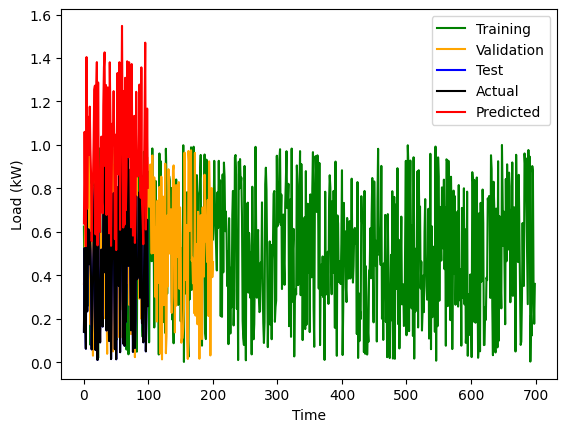

In [8]:
plt.plot(y_train, label='Training', color='green')
plt.plot(np.concatenate([y_train[-1:], y_val]), label='Validation', color='orange')
plt.plot(y_test, label='Test', color='blue')

# Plot the actual and predicted load values
plt.plot(y_test, label='Actual', color='black')
plt.plot(final_preds, label='Predicted', color='red')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Load (kW)')
plt.show()

# HyBrid BiDirectional LSTM Model With XGBoost Model

In [70]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
import numpy as np
import pandas as pd
import xgboost as xgb

# Assume that 'df' is your DataFrame

import numpy as np
import pandas as pd
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load your data
df = pd.read_csv('HourlyData/hourlyDf.csv')  # replace 'your_file.csv' with your file name
df['TimeOfDay'] = df['TimeOfDay'].map({'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3})


data = df.drop(['Timestamp', 'Summe'], axis=1)
X = data
y = df['Summe']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaler_X.fit(X_train)
scaler_y.fit(y_train.values.reshape(-1,1))

X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)
X_val = scaler_X.transform(X_val)

y_train = scaler_y.transform(y_train.values.reshape(-1,1))
y_test = scaler_y.transform(y_test.values.reshape(-1,1))
y_val = scaler_y.transform(y_val.values.reshape(-1,1))

n_future = 24
n_past = 24*3

X_train_seq = []
y_train_seq = []

# Modify the sequence formation process
for i in range(n_past, len(X_train) - n_future + 1):
    X_train_seq.append(X_train[i - n_past:i])
    y_train_seq.append(y_train[i + n_future - 1])

X_train, y_train = np.array(X_train_seq), np.array(y_train_seq)
X_train, y_train = np.array(X_train_seq), np.array(y_train_seq)

lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')

history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=32)

plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

lstm_preds_train = lstm_model.predict(X_train)
lstm_preds_test = lstm_model.predict(X_test)

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Train on original features

xgb_preds = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))  # Predict on original features

final_preds = lstm_preds_test + xgb_preds.reshape(-1, 1)

final_preds_inv = scaler_y.inverse_transform(final_preds)  # Inverse transform to get original scale
y_test_inv = scaler_y.inverse_transform(y_test)  # Inverse transform to get original scale

mse = mean_squared_error(y_test_inv[:len(final_preds)], final_preds_inv)  # Make sure to align length of y_test
print('Mean Squared Error:', mse)


2023-07-08 13:15:55.295371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 13:15:55.297206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 13:15:55.298428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/2


2023-07-08 13:15:56.132178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 13:15:56.133484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 13:15:56.134870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

279/282 [============================>.] - ETA: 0s - loss: 0.0076

ValueError: in user code:

    File "/home/iffi/anaconda3/envs/tensorflow_updated/lib/python3.11/site-packages/keras/engine/training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "/home/iffi/anaconda3/envs/tensorflow_updated/lib/python3.11/site-packages/keras/engine/training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/iffi/anaconda3/envs/tensorflow_updated/lib/python3.11/site-packages/keras/engine/training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "/home/iffi/anaconda3/envs/tensorflow_updated/lib/python3.11/site-packages/keras/engine/training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "/home/iffi/anaconda3/envs/tensorflow_updated/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/iffi/anaconda3/envs/tensorflow_updated/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 72, 9), found shape=(None, 9)


In [68]:
y_train

array([ 17289.73105267, 203999.71695954,  10179.37093554, ...,
        18500.55694133,  10111.39679782,  12917.53442489])